# Using Landsat ARD

This notebook demonstrates how to retrieve and use Landsat ARD. _It is a work in progress!_

## The Python LCMAP Client

To use the client, import the `lcmap_client` module and instantiate a client object. The client uses a configuration file in your home directory `~/.usgs/lcmap.ini` to locate the LCMAP REST API.

In [3]:
from lcmap.client import Client
client = Client();

## Finding Tiles

Finding tiles requires a universal band identifier (UBID), a point, and a time interval. This will return a pair of values: a tile specification and a list of tiles.

* A UBID is a combination of mission, sensor, and band short name.
* X and Y values are in terms of projection system coordinates.
* Times are specified as ISO-8601 dates.

In the future, changes will be made to support a variety parameter types to make usage more convenient.

In [67]:
ubid = "LANDSAT_7/ETM/sr_band1"
x = -2062080
y =  2952960
t1 = "2002-05-01"
t2 = "2002-10-01"
spec, tiles = client.data.tiles(ubid, x, y, t1, t2)

Let's examine the first tile and see how to retrieve a pixel value.

In [68]:
len(tiles)

20

In [18]:
tile = tiles[1]
tile.source

'LE70460282002130EDC00'

Each tile has a data property that can be used to access and, masked, scaled, and shaped set of values.

In [23]:
tile.data[0,0]

0.045100000000000001

You may also get data values in terms of the projection system coordinates. This is much more convenient than calculating the raster grid projection coordinate containing a point in the projection system on your own.

In [20]:
tile[x, y]

0.045100000000000001

Notice that the point you specify can be "off" the implicit grid, here we move east/south by two meters. These values are _snapped_ to the nearest point.

In [21]:
tile[x+2, y-2] # 2 meters east, 2 meters south...

0.045100000000000001

If you needed, you can also get the acquisition date and scene ID of each tile. Notice that the stack of tiles contains data from multiple scenes.

In [22]:
[(t.acquired, t.source, t.data[0,0]) for t in tiles]

[('2002-05-01T00:00:00Z', 'LE70470282002121PAC01', masked),
 ('2002-05-10T00:00:00Z', 'LE70460282002130EDC00', 0.045100000000000001),
 ('2002-05-17T00:00:00Z', 'LE70470282002137EDC00', masked),
 ('2002-05-26T00:00:00Z', 'LE70460282002146EDC00', masked),
 ('2002-06-02T00:00:00Z', 'LE70470282002153EDC00', masked),
 ('2002-06-11T00:00:00Z', 'LE70460282002162EDC00', 0.022800000000000001),
 ('2002-06-18T00:00:00Z', 'LE70470282002169EDC00', masked),
 ('2002-06-27T00:00:00Z', 'LE70460282002178EDC00', masked),
 ('2002-07-04T00:00:00Z', 'LE70470282002185EDC00', masked),
 ('2002-07-13T00:00:00Z', 'LE70460282002194EDC00', masked),
 ('2002-07-20T00:00:00Z', 'LE70470282002201EDC00', masked),
 ('2002-07-29T00:00:00Z', 'LE70460282002210EDC00', masked),
 ('2002-08-05T00:00:00Z', 'LE70470282002217EDC00', masked),
 ('2002-08-14T00:00:00Z', 'LE70460282002226EDC00', 0.017400000000000002),
 ('2002-08-21T00:00:00Z', 'LE70470282002233EDC00', masked),
 ('2002-08-30T00:00:00Z', 'LE70460282002242EDC00', 0.04139

## Creating an Image

The client currently provides very basic data retrieval functionality. If you want to get tiles for a wider area and multiple bands you need to implement a function. Note, this function omits the returned specs because we don't have a use for the information they contain.

In [25]:
def get_tiles(bands, x1, y1, x2, y2, t1, t2):
    xs = range(x1, x2,  128*30)
    ys = range(y1, y2, -128*30)
    results = []
    for band in bands:
        for x in xs:
            for y in ys:
                _, tiles = client.data.tiles(band, x, y, t1, t2)
                results.append(tiles)
    return results

Now, we use the `get_tiles` function to retrieve multiple bands of data over a wide area. The returned value is a list-of-lists of tiles.

In [70]:
bands = ["LANDSAT_7/ETM/sr_band3", "LANDSAT_7/ETM/sr_band4", "LANDSAT_7/ETM/sr_band4"]
x1, y1 = x, y
x2, y2 = x1+(128*30*1), y1-(128*30*1)
tiles = get_tiles(bands, x1, y1, x2, y2, t1, t2)

### Melding Tile Data

Once we have a list-of-lists, we can meld them into three "layers" of data by defining another function. We use `numpy` and `pandas` to create this new data structure.

In [75]:
import numpy as np
from itertools import groupby

def meld(ts, ix):
    ts = [t[ix] for t in ts]
    bands = []
    for band, by_band in groupby(ts, key=lambda t: t.ubid):
        rows = []
        foo = sorted(by_band, key=lambda t: t.y, reverse=True)
        for x, by_row in groupby(foo, key=lambda t: t.y):
            bar = sorted(by_row, key=lambda t: t.x)
            data = [t.data for t in bar]
            rows.append(np.hstack(data))
        bands.append(np.vstack(rows))
    return np.dstack(bands)

### Rendering an Image

In order to render an image, we use `matplotlob` and `skimage` -- the latter has a function for color correcting images.

In [80]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.cm as cm
import matplotlib.dates as mdates
import skimage.exposure as ex
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We use adaptive histogram equalization in order to color correct imagery for a single scene.

In [79]:
rgb = meld(tiles, 1)
norm = mc.Normalize(0.0, 1.0, clip=True)
equalized = ex.equalize_adapthist(norm(rgb), clip_limit=0.05)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(equalized, interpolation='nearest')

ValueError: all the input array dimensions except for the concatenation axis must match exactly

## Plotting a Time Series

We can plot values from multiple bands too.

In [89]:
_, rt_L7 = client.data.tiles("LANDSAT_7/ETM/sr_band3", x, y, t1, t2)
_, gt_L7 = client.data.tiles("LANDSAT_7/ETM/sr_band2", x, y, t1, t2)
_, bt_L7 = client.data.tiles("LANDSAT_7/ETM/sr_band1", x, y, t1, t2)

In [91]:
point = 1,1 # raster grid coordinate (not projection system)
r5 = [t.data[point] for t in rt_L7]
g5 = [t.data[point] for t in gt_L7]
b5 = [t.data[point] for t in bt_L7]

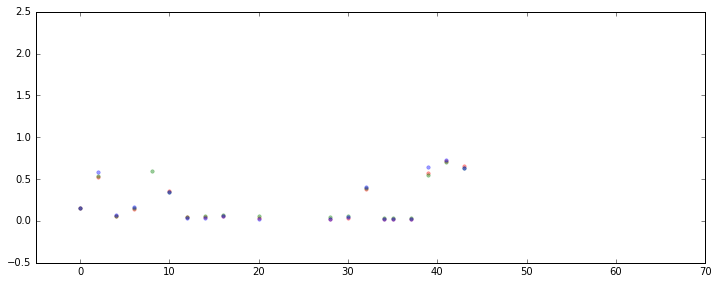

In [92]:
fig = plt.figure(figsize=(12, 4.5))
fig.hold(True)
ax = fig.add_subplot(111)
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-5, 70)
ax.plot(r5, 'r.', ms=7, alpha=0.4)
ax.plot(g5, 'g.', ms=7, alpha=0.4)
ax.plot(b5, 'b.', ms=7, alpha=0.4)
plt.show()

## Calculating NDVI

"The Normalized Difference Vegetation Index (NDVI) is an index of plant “greenness” or photosynthetic activity, and is one of the most commonly used vegetation indices". Let's take a look at how to use Landsat ARD to in order to calculate NDVI. First, let's retrieve the IR and Red bands from Landsat 5.

In [185]:
t1, t2 = '2002-01-01', '2003-01-01'
_, ir = client.data.tiles("LANDSAT_7/ETM/sr_band4", x, y, t1, t2)
_, red = client.data.tiles("LANDSAT_7/ETM/sr_band3", x, y, t1, t2)
_, ndvi = client.data.tiles("LANDSAT_7/ETM/sr_ndvi", x, y, t1, t2)

In [207]:
ir_winter = ir[12]
red_winter = red[12]
ir_summer = ir[20]
red_summer = red[20]
saved = ndvi[20]

In [208]:
ir_winter.data

masked_array(data =
 [[ 0.1809  0.1985  0.2249 ...,  0.1853  0.2073  0.2292]
 [ 0.1764  0.1941  0.2073 ...,  0.2029  0.2292  0.2249]
 [ 0.1765  0.1853  0.2073 ...,  0.1941  0.2424  0.2292]
 ..., 
 [ 0.2117  0.2161  0.2117 ...,  0.172   0.1808  0.2072]
 [ 0.2161  0.2292  0.1985 ...,  0.2028  0.1808  0.1676]
 [ 0.2161  0.1589  0.1368 ...,  0.2248  0.1984  0.1852]],
             mask =
 False,
       fill_value = -9999)

This retrieves a stack of tiles during June of 1985 and another stack of tiles during January of the following year. 

In [209]:
red1, ir1 = red_summer.data, ir_summer.data
ndvi_summer = (ir1-red1)/(ir1+red1)
red2, ir2 = red_winter.data, ir_winter.data
ndvi_winter = (ir2-red2)/(ir2+red2)

Now we can draw the calculated NDVI, the original red band and the original IR band.

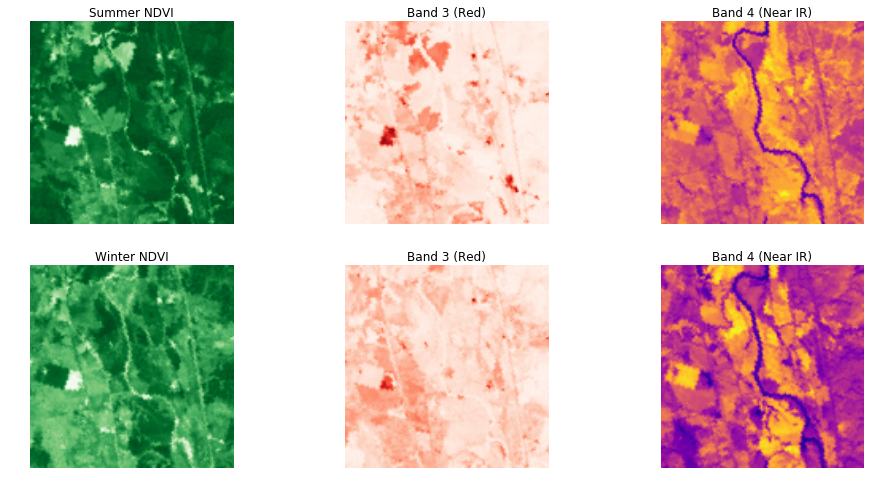

In [210]:
fig = plt.figure(figsize=(16,8))

s1 = fig.add_subplot(2,3,1)
s1.axis('off')
s1.imshow(ndvi_summer, cmap='Greens')
s1.set_title("Summer NDVI")

s2 = fig.add_subplot(2,3,2)
s2.axis('off')
s2.imshow(red1, cmap='Reds')
s2.set_title("Band 3 (Red)")

s3 = fig.add_subplot(2,3,3)
s3.axis('off')
s3.imshow(ir1, cmap='plasma')
s3.set_title("Band 4 (Near IR)")

s1 = fig.add_subplot(2,3,4)
s1.axis('off')
s1.imshow(ndvi_winter, cmap='Greens')
s1.set_title("Winter NDVI")

s2 = fig.add_subplot(2,3,5)
s2.axis('off')
s2.imshow(red2, cmap='Reds')
s2.set_title("Band 3 (Red)")

s3 = fig.add_subplot(2,3,6)
s3.axis('off')
s3.imshow(ir2, cmap='plasma')
s3.set_title("Band 4 (Near IR)")

In [211]:
ir_summer.acquired, saved.acquired, ir_winter.acquired

('2002-06-11T00:00:00Z', '2002-06-11T00:00:00Z', '2002-04-08T00:00:00Z')

Landsat ARD only will include surface reflectance and top of atmosphere. However, our prototype dataset (from ESPA) included indices (NDVI, EVI, etc...) so we have a basis for comparing the calculated value against the value that was ingested.

In [166]:
ndvi_summer[0,0], saved.data[0,0]

(0.91087579969115384, 0.91090000000000004)

We can count the number of calculated values that differ significantly from the ESPA data.

In [167]:
ndvi_diff = ndvi_summer - saved
ndvi_diff[ndvi_diff > 0.0001].count()

0

Zero!

### Conclusions

Using the LCMAP API and Python Client Library to retrieve Lansat ARD makes it possible to get data in a familiar format quickly. We need lots of feedback so that we can add features that further simplify retrieving and structuring data.